# Sparse Dreams: Sparse Coding & Wake-Sleep Algorithm

In [415]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
import scipy
from scipy import ndimage
import math
from tqdm import tqdm

# See helmholtz.py and sparse_coding.py
import helmholtz as hm
from sparse_coding import calc_LCA, calc_Phi, SparseCodingModel

# To Delete Later
import tensorflow as tf
from sklearn.datasets import fetch_olivetti_faces

## Load Raw Images

In [416]:
def get_face_images(num_images=5):
    faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True)
    n_samples, n_features = faces.shape
    image_shape = (64, 64)
    # global centering
    faces_centered = faces - faces.mean(axis=0)
    # local centering
    faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)
    return faces_centered[:num_images], image_shape

# Gets MNIST images for a given number. (ie. if number=1, images of 1 are returned)
def get_mnist_images(num_images=5, number=8):
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    X = ((np.concatenate((x_train, x_test), axis = 0))).astype(float) 
    y = np.concatenate((y_train, y_test), axis = 0)
    digits = X[np.where(y == number)]
    digits = (digits.reshape((len(digits), 1, 28*28))).astype(float)
    return digits[:num_images], (28, 28)

def get_bar_images(num_images=5, x_dim=16, y_dim=16):
    X = []
    for i in range(num_images):
        img = np.zeros((x_dim, y_dim))
        x_bars = np.random.choice(np.arange(x_dim), np.random.randint(x_dim // 1.5), replace=False)
        y_bars = np.random.choice(np.arange(y_dim), np.random.randint(y_dim // 1.5), replace=False)
        y_bars = y_bars[:np.random.randint(y_dim)]
        for x in x_bars:
            img[x, :] += np.ones(y_dim)
        for y in y_bars:
            img[:, y] += np.ones(x_dim)
        img = img.reshape((x_dim * y_dim))
        X.append(img)
    return np.array(X), (x_dim, y_dim)

## Filter Functions

In [417]:
def contrast_images(images):
    return images**2

def undo_contrast_images(images):
    return np.sqrt(images)

def blur_images(images, scale=3):
    return np.array([ndimage.gaussian_filter(img, scale) for img in images])
    
def sharpen_images(images, scale=5):
    return np.array([img + scale * (img - ndimage.gaussian_filter(img, 1)) for img in images])

# Create Sparse Coding Model

### Configure Parameters

In [420]:
num_images=100
n_activations = 32
alpha = 0.001
num_steps = 100
get_images = get_face_images #function to load the images
test_train_ratio = .8

# The following are useful/necessary to find proper sparse codes
do_contrast = True
do_sharpen = False
do_blur = False

### Train Model

In [421]:
images, image_shape = get_images(num_images=num_images)
input_size = image_shape[0]*image_shape[1]
if (do_contrast):
    images = contrast_images(images)
if (do_sharpen):
    images = sharpen_images(images)
if (do_blur):
    images = blur_images(images)  
test_train_split = int(num_images*test_train_ratio)
X_train, X_test = images[:test_train_split], images[test_train_split:]

model = SparseCodingModel(input_size, n_activations, alpha)
model.train(X_train, alpha, num_steps)

100% (100 of 100) |######################| Elapsed Time: 0:02:16 Time:  0:02:16


## Feature Library

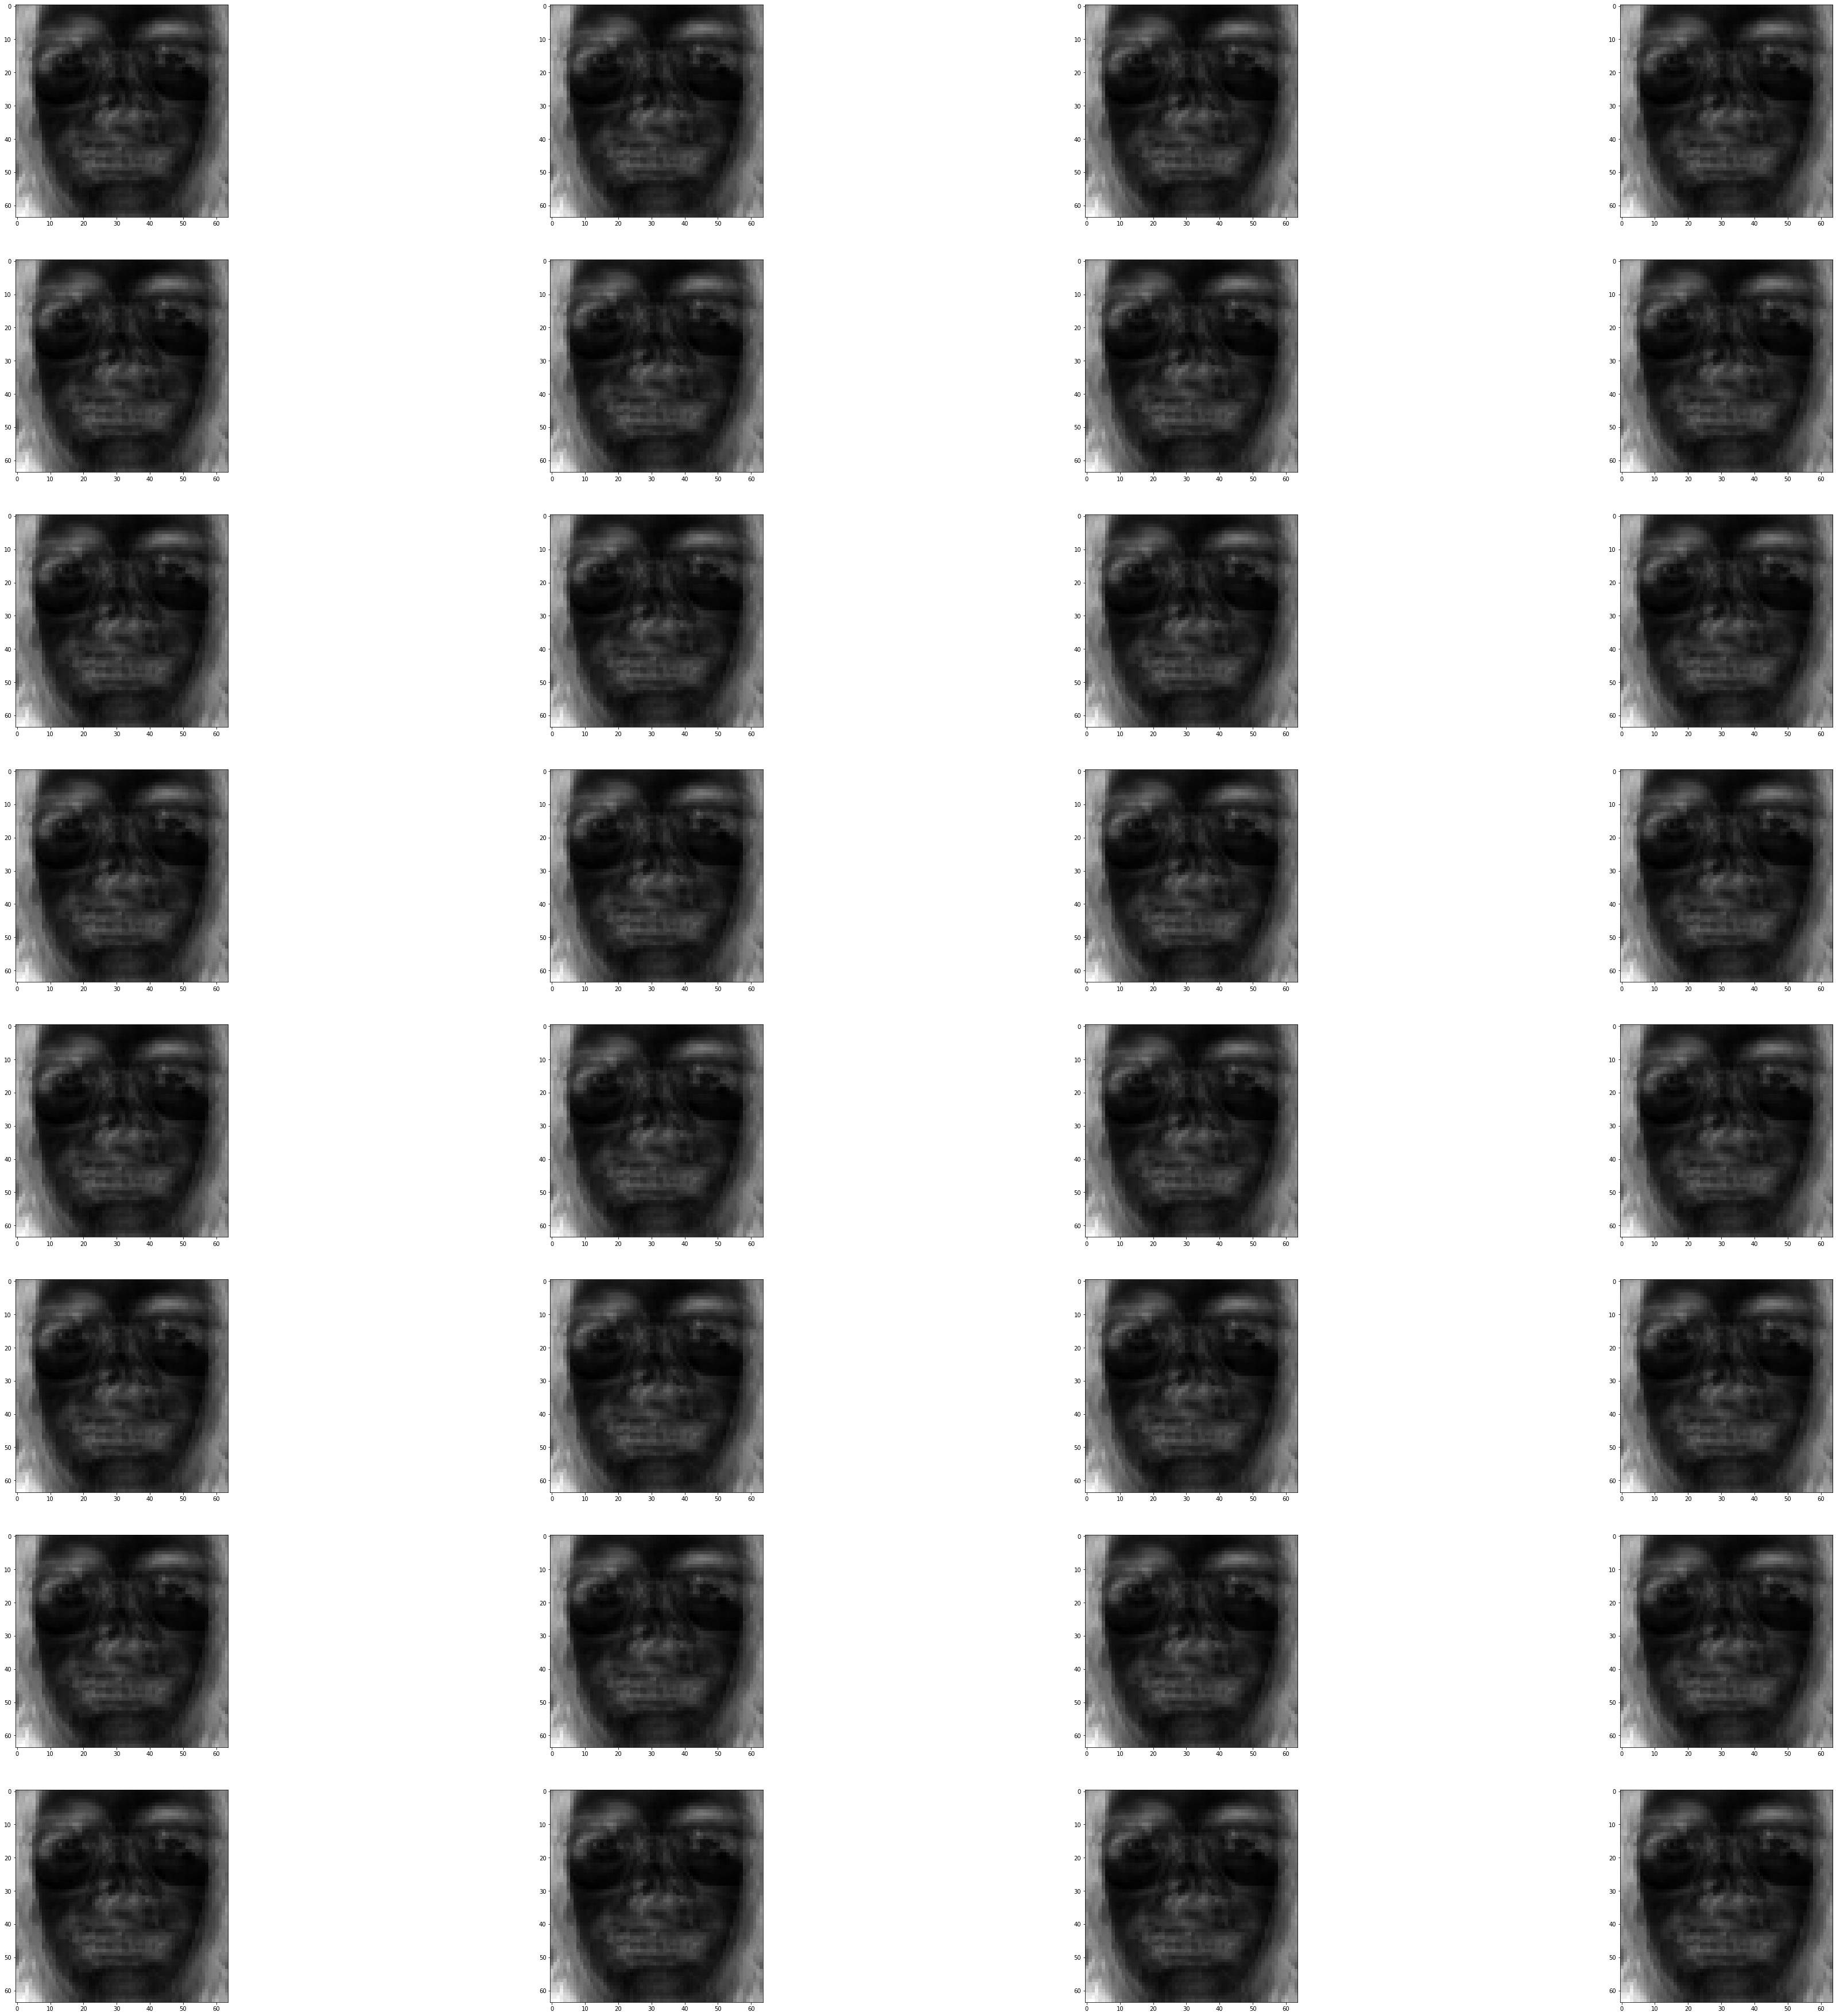

In [422]:
fig=plt.figure(figsize=image_shape)
columns = 4
rows = 8
for i in range(n_activations):
    img = model.Phi[:, i].reshape(image_shape)
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(img, cmap='gray')
plt.show()

### Predict Activations From Test Images

In [401]:
activations = model.predict(X_train, num_steps=num_steps)


  0%|          | 0/32 [00:00<?, ?it/s]

(4096, 512)
(512, 1)



 47%|████▋     | 15/32 [10:48<12:04, 42.62s/it]/Users/apottaba/Desktop/VisSci 265/dreammachines/helmholtz.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))

100%|██████████| 32/32 [23:27<00:00, 44.43s/it]

Dream Info: 32000


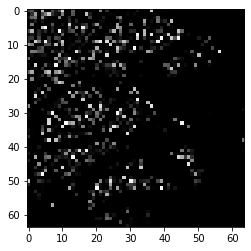


100%|██████████| 320/320 [00:01<00:00, 186.97it/s]

Animation Creation Started
Animation Creation Finished


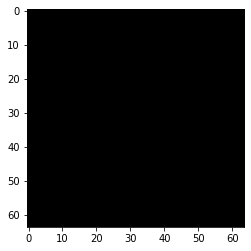

In [411]:
h = hm.helmholtz([4096,512], 'beta', .1) #TODO: How are the [] params set?

for i in tqdm(range(n_activations)):
    img = model.Phi[:, i].reshape(image_shape)
    h.train(image)
    
# for image in tqdm(temp):
#     image = image.reshape(1, -1)
#     # print(f"image: {image.shape}")
#     h.train(image)

dreams = h.dreams
print("Dream Info:", len(dreams)), len(dreams[0])

plt.figure()
plt.imshow(dreams[-1].reshape(image_shape), cmap = 'gray')
plt.show()

frames = [] # for storing the generated images
fig = plt.figure()
for dream in tqdm(dreams[::100]):
    dream = dream.reshape(image_shape)
    frames.append([plt.imshow(dream,cmap = 'gray',animated=True)])

print('Animation Creation Started')
ani = animation.ArtistAnimation(fig, frames, interval=10, blit=True)
ani.save('faces_dreaming_2.gif')
print('Animation Creation Finished')

plt.show()

## Convert Wake-Sleep Output --> Activations

In [424]:
#TODO
new_activations = activations

## Generate Images from Activations

In [441]:
X_pred = model.generate(new_activations)

In [442]:
if (do_contrast):
    X_pred = undo_contrast_images(X_pred)
    X_test = undo_contrast_images(X_test)
if (do_sharpen):
    #TODO: May need fixing
    X_pred = blur_images(images)
    X_test = blur_images(images)
if (do_blur):
    #TODO: May need fixing
    X_pred = sharpen_images(images)
    X_test = sharpen_images(images)

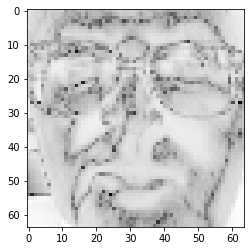

In [443]:
plt.imshow(X_test[0].reshape(image_shape), cmap='gray')

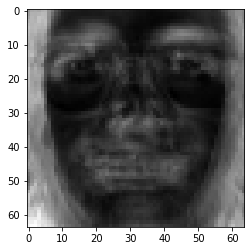

In [444]:
plt.imshow(X_pred[:, 0].reshape(image_shape), cmap='gray')

# Random Stuff to Remove

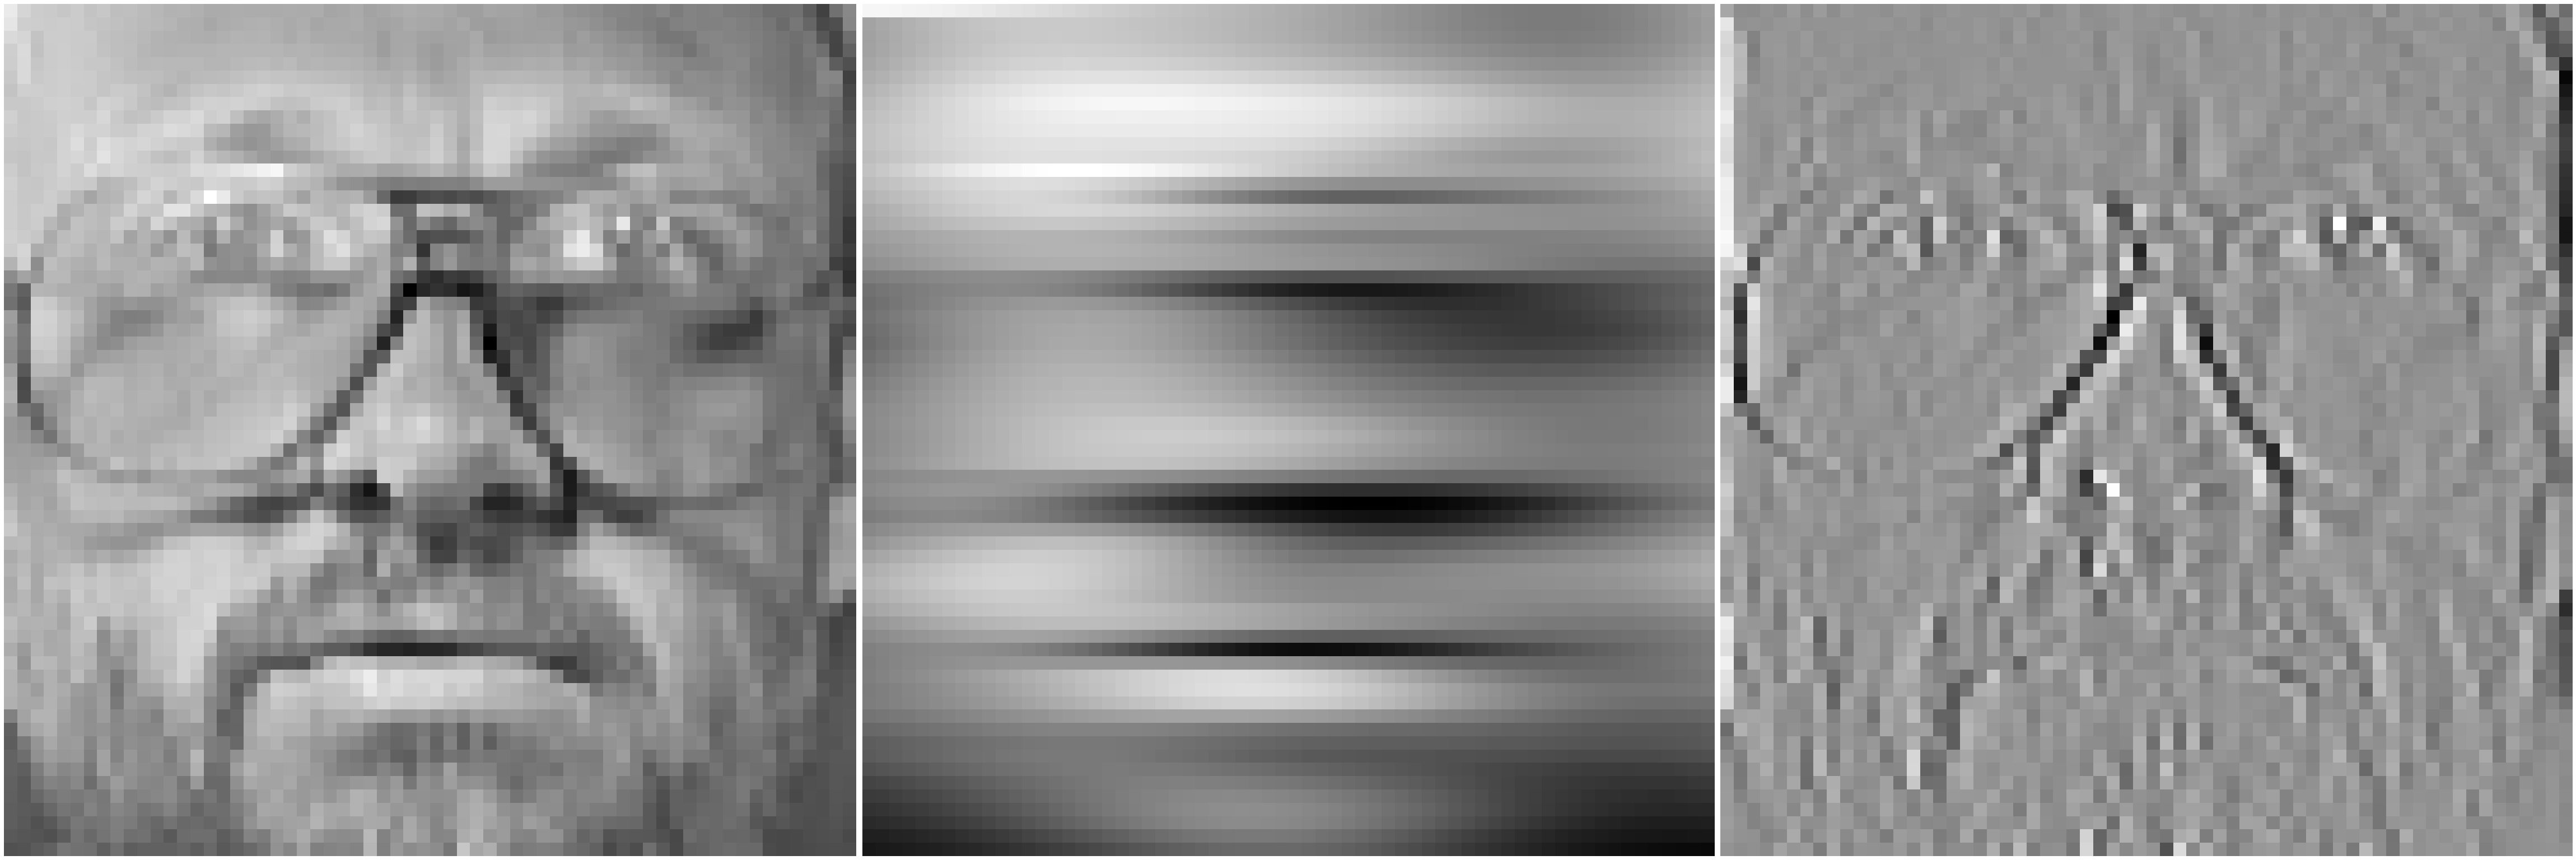

In [232]:
f, _ = get_face_images(1)
blurred_f = ndimage.gaussian_filter(f, 10)
alpha = 100
filter_blurred_f = ndimage.gaussian_filter(f, 1)
sharpened = f + alpha * (f - filter_blurred_f)

plt.figure(figsize=(64, 64))

plt.subplot(131)
plt.imshow(f.reshape(image_shape), cmap='gray')
plt.axis('off')
plt.subplot(132)
plt.imshow(blurred_f.reshape(image_shape), cmap='gray')
plt.axis('off')
plt.subplot(133)
plt.imshow(sharpened.reshape(image_shape), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

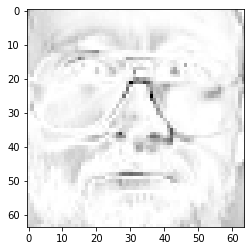

In [235]:
img, _ = get_face_images(num_images=1)
img = img*img*-1
plt.imshow(img.reshape(image_shape), cmap='gray')

11493376/11490434 [==============================] - 1s 0us/step
(70000, 28, 28) (70000,)
(6825, 1, 784)


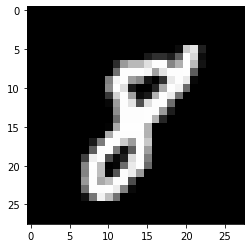

  0%|          | 0/50 [00:00<?, ?it/s]

(784, 64)
(64, 32)
(32, 1)


/Users/apottaba/Desktop/VisSci 265/dreammachines/helmholtz.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
100%|██████████| 50/50 [00:49<00:00,  1.14s/it]

50000


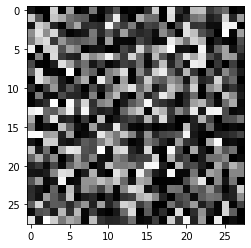

100%|██████████| 500/500 [00:00<00:00, 1506.86it/s]


Animation Creation Finished


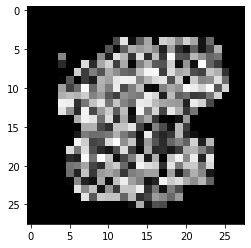

In [391]:
import numpy as np
import helmholtz as hm #helmholtz_machine
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.cm as cm
import matplotlib.animation as animation

# Load in MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# X = (np.concatenate((x_train, x_test), axis = 0).reshape((len(x_train)+len(x_test), 28*28)) > .5).astype(float)
X = ((np.concatenate((x_train, x_test), axis = 0))).astype(float) 
y = np.concatenate((y_train, y_test), axis = 0)
print(X.shape, y.shape)

# Isolate Ones
digit = X[np.where(y == 8)]
digit = (digit.reshape((len(digit), 1, 28*28))).astype(float)
print(digit.shape)
plt.imshow(digit.reshape((len(digit),28,28))[0]/255, cmap='gray')
plt.show()

h = hm.helmholtz([784,64,32], 'beta', .1)
for image in tqdm(digit[:50]):
    # print(f"image: {image.shape}")
    h.train(image)

dreams = h.dreams
print(len(dreams)), len(dreams[0])

plt.figure()
plt.imshow(dreams[-1].reshape(28,28), cmap='gray')
plt.show()

frames = [] # for storing the generated images
fig = plt.figure()
for dream in tqdm(dreams[::100]):
    dream = dream.reshape(28,28)
    frames.append([plt.imshow(dream,animated=True, cmap='gray')])

ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True)
ani.save('dreaming.gif')
print('Animation Creation Finished')

plt.show()


  0%|          | 0/5 [00:00<?, ?it/s]

(400, 4096)
Input Shape: (5, 4096)
Example Face
(4096, 512)
(512, 1)



100%|██████████| 5/5 [03:30<00:00, 42.10s/it]

Dream Info: 5000


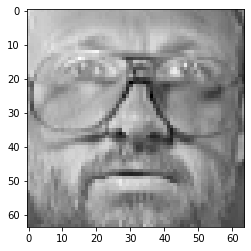

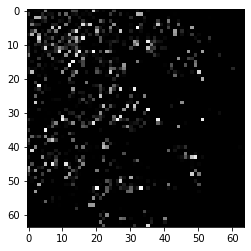


100%|██████████| 50/50 [00:00<00:00, 996.31it/s]

Animation Creation Started
Animation Creation Finished


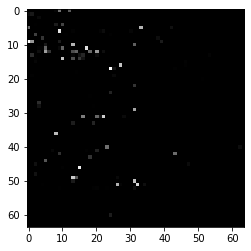

In [393]:
import numpy as np
import helmholtz as hm
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.cm as cm
import matplotlib.animation as animation
from sklearn.datasets import fetch_olivetti_faces
import math

faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True)
n_samples, n_features = faces.shape
image_shape = (64, 64)
print(faces.shape)

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

temp = np.vstack([faces_centered[0]] * 5)
# temp = np.concatenate((faces_centered, faces_centered)) # all faces 2x
print(f"Input Shape: {temp.shape}")

print("Example Face")
plt.imshow(temp[0].reshape(image_shape)/255, cmap = 'gray')

h = hm.helmholtz([4096,512], 'beta', .1)
for image in tqdm(temp):
    image = image.reshape(1, -1)
    # print(f"image: {image.shape}")
    h.train(image)

dreams = h.dreams
print("Dream Info:", len(dreams)), len(dreams[0])

plt.figure()
plt.imshow(dreams[-1].reshape(image_shape), cmap = 'gray')
plt.show()

frames = [] # for storing the generated images
fig = plt.figure()
for dream in tqdm(dreams[::100]):
    dream = dream.reshape(image_shape)
    frames.append([plt.imshow(dream,cmap = 'gray',animated=True)])

print('Animation Creation Started')
ani = animation.ArtistAnimation(fig, frames, interval=10, blit=True)
ani.save('faces_dreaming_2.gif')
print('Animation Creation Finished')

plt.show()

In [410]:
from time import sleep
for i in tqdm(range(10)):
    sleep(1)


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]